# EsGB 球对称标量化黑洞 — Chebyshev 伪谱 BVP 求解器

## 物理设置

- 理论：Einstein-scalar-Gauss-Bonnet，耦合函数 $f(\phi)=\phi^2+\beta\phi^4$
- 度规重定义（提取视界奇异因子）：$e^A = h_t(1+x)/2$，$e^B = G_t \cdot 2/(1+x)$
- 坐标：$x\in[-1,1]$，$x=-1$ 视界，$x=1$ 无穷远；$r=2r_h/(1-x)$
- 参数约束：稳定性分析要求 $\beta < -0.40$

In [2]:
# ══════════════════════════════════════════════════════════════════
# 单解绘图（调试用）——修改参数后运行本单元格
rh         = 1.0
alpha      = 0.3
beta       = -0.6
phi_h_init = 0.82
N          = 13
# ══════════════════════════════════════════════════════════════════
import importlib, esgb_solver_core as core; importlib.reload(core)
import numpy as np
import matplotlib; matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sol = core.solve(rh=rh, alpha=alpha, beta=beta,
                 phi_h_init=phi_h_init, N=N, verbose=True)
if sol.phi_h < 0:                          # Z₂ 翻转，统一取正
    sol.phi, sol.Q, sol.phi_h = -sol.phi, -sol.Q, -sol.phi_h
print(f'\n  phi_h={sol.phi_h:.6f}  M={sol.M_ADM:.6f}  Q={sol.Q:.6f}  ||R||={sol.residual:.2e}')

rmin = rh * 1.04
fig, axes = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)
fig.suptitle(rf'EsGB  $r_h={rh}$, $\alpha={alpha}$, $\beta={beta}$, '
             rf'$\phi_h={sol.phi_h:.4f}$, $M={sol.M_ADM:.4f}$, $Q={sol.Q:.4f}$',
             fontsize=10)

for ax, key, ylabel, title in zip(
        axes,
        ['gtt',          'grr',          'phi'],
        [r'$-g_{tt}$',   r'$g_{rr}$',    r'$\phi$'],
        [r'(a) $-g_{tt}$', r'(b) $g_{rr}$', r'(c) $\phi$']):
    mask = sol.r >= rmin
    r_m  = sol.r[mask]
    y    = {'gtt': sol.gtt, 'grr': sol.grr, 'phi': sol.phi}[key][mask]
    ax.plot(r_m, y, color='#1f4e79', lw=1.6, label='EsGB')
    if key == 'phi':
        ax.axhline(0., color='tomato', lw=1.2, ls='--', alpha=0.7, label='Schwarzschild')
    else:
        ys = {'gtt': sol.gtt_schw, 'grr': sol.grr_schw}[key][mask]
        ax.plot(r_m, ys, color='tomato', lw=1.0, ls='--', alpha=0.7, label='Schwarzschild')
        if key == 'grr':
            ax.set_ylim(bottom=0.0, top=sol.grr[mask].max() * 1.10)
    ax.axvline(rh, lw=0.5, color='#aaaaaa', ls=':', zorder=1)
    ax.set_xscale('log'); ax.set_xlim(rh * 0.75, 5e3)
    ax.set_xlabel(r'$r/r_h$', fontsize=10); ax.set_ylabel(ylabel, fontsize=10)
    ax.set_title(title, fontsize=9, pad=3)
    ax.legend(fontsize=8, framealpha=0.9)
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.grid(True, which='major', lw=0.3, color='#bbbbbb')
    ax.grid(True, which='minor', lw=0.15, color='#dddddd')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(
        lambda v, _: f'{v:.3g}' if v < 10 else f'{int(v)}' if v < 1000 else f'$10^{{{int(np.log10(v))}}}$'))

plt.savefig('esgb_single.png', dpi=150)
print('Saved  esgb_single.png')


[OK]  alpha=0.3, beta=-0.6, phi_h=0.91466, M=0.68136, Q=2.01746, ||R||=3.86e-10

  phi_h=0.914656  M=0.681361  Q=2.017463  ||R||=3.86e-10
Saved  esgb_single.png


## $\phi_h$ 的扫描与分支 ##

视界正则性条件含开根号，要求判别式非负：

$$\Delta = 1 - \frac{96\,(\alpha f'(\phi_h))^2}{r_h^4} \geq 0$$

其中 $f'(\phi) = 2\phi + 4\beta\phi^3 = 2\phi(1+2\beta\phi^2)$。

这给出：

$$|f'(\phi_h)| \leq \frac{r_h^2}{\sqrt{96}\,\alpha}$$

**关键：** $\beta < 0$ 时 $f'(\phi)$ 有极大值在 $\phi^* = \sqrt{-1/(6\beta)}$，极大值为 $f'(\phi^*) = \frac{4}{3}\phi^*$。

临界耦合参数（解析结果）：

$$\beta_{\rm crit} = -\frac{256\,\alpha^2}{9\,r_h^4}$$

- 若 $\beta \leq \beta_{\rm crit}$（$|\beta|$ 较大）：$f'_{\max}$ 不超过上界，$\phi_h$ **无上界限制**（如 $\beta = -0.5$，$\beta_{\rm crit} \approx -0.444$）
- 若 $\beta > \beta_{\rm crit}$（$|\beta|$ 较小）：存在两个临界根 $\phi_{c1} < \phi^* < \phi_{c2}$，**只允许 $\phi_h < \phi_{c1}$ 或 $\phi_h > \phi_{c2}$**（如 $\beta = -0.1$）

运行下方单元格可打印当前参数下的允许范围，并扫描所有解分支。

In [6]:
# ══════════════════════════════════════════════════════════════════
# 在这里修改参数，然后运行本单元格
rh    = 1.0
alpha = 0.1
beta  = -0.6
N     = 13
# ══════════════════════════════════════════════════════════════════
import numpy as np

def phi_h_allowed_range(rh, alpha, beta):
    '''
    解析计算视界正则条件对 phi_h 的约束范围。
    返回: (phi_c1, phi_c2)
      无禁戒 => (inf, inf)，phi_h 可任意取值
      有禁戒 => 禁戒区间为 (phi_c1, phi_c2)，允许区间为 (0, phi_c1) ∪ (phi_c2, +∞)
    '''
    limit     = rh**2 / (np.sqrt(96) * alpha)
    beta_crit = -256.0 * alpha**2 / (9.0 * rh**4)

    if beta >= 0 or beta <= beta_crit:
        return np.inf, np.inf

    phi_star = np.sqrt(-1.0 / (6.0 * beta))
    fdot_max = (4.0 / 3.0) * phi_star
    if fdot_max <= limit + 1e-12:
        return np.inf, np.inf

    coeffs   = [4*beta, 0, 2, -limit]
    roots    = np.roots(coeffs)
    pos_real = sorted([r.real for r in roots
                       if abs(r.imag) < 1e-8 and r.real > 0])
    return pos_real[0], pos_real[1]


def _ceil2(x):
    '''将 x 向上取整到两位小数（银行家舍入后若仍 <= x 则再加 0.01）'''
    r = round(float(x), 2)          # Python round() 即四舍六入五取偶
    return r if r > x else r + 0.01


def scan_phi_branches(rh, alpha, beta, N=13, phi_scan=None):
    '''
    扫描 phi_h_init，寻找所有收敛的解分支。
    返回: [(phi_h_init, phi_h_sol, M_ADM, Q, residual, ht_h, dhtx_h), ...]
      ht_h   : 视界处 ht 节点值（x=-1 端点，应接近 Robin BC 所要求的值）
      dhtx_h : 视界处 ht 关于 x 的导数（由微分矩阵 D 作用于节点向量）
    '''
    import importlib, esgb_solver_core as core; importlib.reload(core)

    phi_c1, phi_c2 = phi_h_allowed_range(rh, alpha, beta)
    if phi_scan is None:
        if np.isfinite(phi_c1):
            # 有禁戒区间：同时扫描两段允许区间
            #   第一段 (0, phi_c1)：取 [0.02, phi_c1*0.90]，12 点
            #   第二段 (phi_c2, +∞)：起点取 phi_c2 向上保留两位小数（银行家舍入），13 点
            seg1    = np.linspace(0.02, phi_c1 * 0.90, 12)
            seg2_lo = _ceil2(phi_c2)                          # 经验起点，整洁且稳定
            seg2    = np.linspace(seg2_lo, seg2_lo + phi_c2 * 3.0, 13)
            phi_scan = np.concatenate([seg1, seg2])
        else:
            # 无禁戒区间：以 phi* 为中心向两侧扫描
            phi_star = np.sqrt(-1.0 / (6.0 * beta)) if beta < 0 else 1.0
            phi_scan = np.linspace(0.02, phi_star * 1.5, 25)

    x_nd, D, D2 = core.chebyshev_matrix(N)

    results = []
    for phi0 in phi_scan:
        sol = core.solve(rh=rh, alpha=alpha, beta=beta,
                         phi_h_init=phi0, N=N, verbose=False)
        if sol.converged:
            # EsGBSolution 未存储节点向量，用收敛的 phi_h 重跑一次 Newton
            # 以获取节点级别的 ht 和 dhtx（收敛极快，通常 1 步）
            u0 = np.zeros(3*(N+1))
            u0[:N+1] = 1.;  u0[N+1:2*(N+1)] = 1.
            u0[2*(N+1):] = sol.phi_h * (1. - x_nd) / 2.
            def F(u): return core.build_residual(u, x_nd, D, D2, rh, alpha, beta)
            u_sol, _, _ = core.newton_solve(F, u0, verbose=False)
            ht_nodes  = u_sol[:N+1]
            dhtx_h    = (D @ ht_nodes)[N]
            ht_h      = ht_nodes[N]

            results.append((phi0, sol.phi_h, sol.M_ADM, sol.Q, sol.residual,
                            ht_h, dhtx_h))
    return results


# ── 输出 ─────────────────────────────────────────────────────────
beta_crit = -256.0 * alpha**2 / (9.0 * rh**4)
phi_c1, phi_c2 = phi_h_allowed_range(rh, alpha, beta)

print(f"参数：rh={rh},  alpha={alpha},  beta={beta}  (beta_crit={beta_crit:.4f})")
print()
if np.isfinite(phi_c1):
    print(f"phi_h 允许区间：(0, {phi_c1:.4f})  ∪  ({phi_c2:.4f}, +∞)")
    print(f"phi_h 禁戒区间：({phi_c1:.4f}, {phi_c2:.4f})")
else:
    print("phi_h 无上界限制（可任意取值）")
print()

print("── 解分支扫描 ──────────────────────────────────────────")
branches = scan_phi_branches(rh, alpha, beta, N=N)
if branches:
    seen, unique = [], []
    for item in branches:
        ph = item[1]
        if not any(abs(ph - s) < 0.02 for s in seen):
            seen.append(ph); unique.append(item)
    print(f"  {'phi_h':>8}  {'M_ADM':>10}  {'Q':>10}  {'||R||':>8}"
          f"  {'ht_h':>8}  {'dhtx_h':>9}  建议 phi_h_init")
    print(f"  {'-'*8}  {'-'*10}  {'-'*10}  {'-'*8}"
          f"  {'-'*8}  {'-'*9}  {'-'*14}")
    for phi0, ph, M_, Q_, nr, ht_h, dhtx_h in unique:
        tag = '← 平凡解' if abs(ph) < 0.01 else '← 标量化'
        print(f"  {ph:8.5f}  {M_:10.5f}  {Q_:10.5f}  {nr:8.2e}"
              f"  {ht_h:8.5f}  {dhtx_h:9.5f}  {phi0:.3f}  {tag}")
else:
    print("  未找到收敛分支，请调整参数。")


参数：rh=1.0,  alpha=0.1,  beta=-0.6  (beta_crit=-0.2844)

phi_h 无上界限制（可任意取值）

── 解分支扫描 ──────────────────────────────────────────
     phi_h       M_ADM           Q     ||R||      ht_h     dhtx_h  建议 phi_h_init
  --------  ----------  ----------  --------  --------  ---------  --------------
   0.00000     0.50000     0.00000  1.31e-10   1.00000    0.00000  0.020  ← 平凡解
  -0.16638     0.14205    -0.45968  1.64e-10   1.00000    0.00000  0.437  ← 标量化
   0.91498     0.56653     1.88395  7.92e-14   1.00613   -0.01063  0.534  ← 标量化


## 多解对比绘图

在下方单元格中填写若干组 `(alpha, beta, phi_h_init)` 参数，
求解器将自动批量求解并绘制三幅对比图（$g_{tt}$、$g_{rr}$、$\phi$），
每幅图同时显示各 EsGB 解与对应的 Schwarzschild 参考曲线。

> **提示：** 先在上方扫描单元格确认各组参数的合适 `phi_h_init`，再填入下表。

In [7]:
import warnings; warnings.filterwarnings("ignore")
import importlib, esgb_solver_core as core; importlib.reload(core)
import numpy as np
import matplotlib; matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

rcParams.update({
    'font.family'      : 'serif',
    'font.serif'       : ['Times New Roman', 'DejaVu Serif'],
    'mathtext.fontset' : 'stix',
    'axes.labelsize'   : 10,
    'xtick.labelsize'  : 9,
    'ytick.labelsize'  : 9,
    'legend.fontsize'  : 7.5,
    'axes.linewidth'   : 0.8,
    'xtick.major.width': 0.7,
    'ytick.major.width': 0.7,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5,
    'xtick.direction'  : 'in',
    'ytick.direction'  : 'in',
    'xtick.top'        : True,
    'ytick.right'      : True,
    'lines.linewidth'  : 1.2,
})

# ══════════════════════════════════════════════════════════════════
CASES = [
    dict(alpha=0.5, beta=-0.6, phi_h_init=0.86),
    dict(alpha=0.3, beta=-0.6, phi_h_init=0.82),
    dict(alpha=0.1,   beta=-0.6, phi_h_init=0.534),
]
rh_global, N_global = 1.0, 13
# ══════════════════════════════════════════════════════════════════

_COLORS = ['#1f4e79', '#c0392b', '#1e6b3c']
_DASHES = [(None, None), (5, 1.5), (2, 1.5)]
_LW_SOL, _LW_REF = 1.4, 0.85

def _ls(i):
    c, ds = _COLORS[i], _DASHES[i]
    return dict(color=c, lw=_LW_SOL, linestyle='-') if ds[0] is None \
           else dict(color=c, lw=_LW_SOL, linestyle=(0, ds))

def _ls_schw(i):
    c, ds = _COLORS[i], _DASHES[i]
    kw = dict(color=c, lw=_LW_REF, alpha=0.35)
    kw['linestyle'] = '--' if ds[0] is None else (0, ds)
    return kw

# ── 求解 + Z₂ 翻转 ────────────────────────────────────────────────
solutions = []
for kw in CASES:
    sol = core.solve(rh=rh_global, N=N_global, verbose=True, **kw)
    if sol.phi_h < 0:           # Z₂: phi -> -phi 是同一物理解，统一取正
        sol.phi   = -sol.phi
        sol.Q     = -sol.Q
        sol.phi_h = -sol.phi_h
        sol.label = (f'$\\alpha={sol.alpha},\\,\\beta={sol.beta}$'
                     f'  ($\\phi_h={sol.phi_h:.3f}$)')
    solutions.append(sol)
print()

# ── 坐标轴基础格式（log x，可选 log y） ──────────────────────────
def _setup_ax(ax, logy=False):
    ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(
        lambda v, _: (f'{v:.3g}' if v < 10 else
                      f'{int(v)}' if v < 1000 else
                      f'$10^{{{int(np.log10(v))}}}$')))
    ax.set_xlabel(r'$r/r_h$', fontsize=10)
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2)
    ax.grid(True, which='major', lw=0.3,  color='#bbbbbb', zorder=0)
    ax.grid(True, which='minor', lw=0.15, color='#dddddd', zorder=0)

# ── inset 放大图 ──────────────────────────────────────────────────
def _add_inset(ax, solutions, key, x1=3., x2=15.,
               bbox_loc=(0.02, 0.02), logy=False):
    axins = ax.inset_axes([bbox_loc[0], bbox_loc[1], 0.40, 0.38])

    schw_done = set()
    for i, sol in enumerate(solutions):
        mask = (sol.r >= x1) & (sol.r <= x2)
        r_m  = sol.r[mask]
        y    = {'gtt': sol.gtt, 'grr': sol.grr, 'phi': sol.phi}[key][mask]
        axins.plot(r_m, y, **_ls(i), zorder=3)
        rh_k = round(sol.rh, 6)
        if rh_k not in schw_done:
            if key == 'phi':
                axins.axhline(0., lw=_LW_REF, color='#888', ls='--', alpha=0.5)
            else:
                ys = {'gtt': sol.gtt_schw,
                      'grr': sol.grr_schw}[key][mask]
                axins.plot(r_m, ys, **_ls_schw(i), zorder=2)
            schw_done.add(rh_k)

    axins.set_xscale('log')
    if logy:
        axins.set_yscale('log')
    axins.set_xlim(x1, x2)
    axins.xaxis.set_major_formatter(ticker.FuncFormatter(
        lambda v, _: f'{int(v)}' if v >= 1 else f'{v:.1g}'))
    axins.xaxis.set_major_locator(ticker.LogLocator(subs=[1, 2, 3, 5]))
    axins.xaxis.set_minor_locator(ticker.NullLocator())
    axins.tick_params(which='both', direction='in', labelsize=6.5,
                      length=2.5, top=True, right=True)
    axins.grid(True, which='major', lw=0.25, color='#cccccc', zorder=0)

    # y 范围：只取 EsGB 解（不含 Schwarzschild，避免 grr 发散污染）
    ys_esgb = []
    for sol in solutions:
        mask = (sol.r >= x1) & (sol.r <= x2)
        ys_esgb.extend(
            {'gtt': sol.gtt, 'grr': sol.grr, 'phi': sol.phi}[key][mask].tolist())
    ylo, yhi = min(ys_esgb), max(ys_esgb)
    if logy:
        axins.set_ylim(max(ylo / 1.15, 1e-6), yhi * 1.15)
    else:
        pad = max((yhi - ylo) * 0.18, 1e-3)
        axins.set_ylim(ylo - pad, yhi + pad)

    ax.indicate_inset_zoom(axins, edgecolor='#777777', lw=0.7, alpha=0.8)

    for spine in axins.spines.values():
        spine.set_linewidth(0.6)
        spine.set_edgecolor('#777777')

    return axins

# ── 主图 ──────────────────────────────────────────────────────────
rh_val = solutions[0].rh
rmin   = rh_val * 1.04      # 曲线起点（略高于视界）
rmax   = 5e3                # 横轴右端
xleft  = rh_val * 0.75      # 横轴左端（视界左侧留白）

fig, axes = plt.subplots(1, 3, figsize=(10.5, 3.4), constrained_layout=True)

PANEL_CFG = [
    dict(key='gtt',
         ylabel=r'$-g_{tt}(r)$', title=r'(a) $-g_{tt}$',
         legend_loc='lower right',
         inset_bbox=(0.56, 0.42),
         inset_x1=2., inset_x2=15.,
         logy=False,
         ylim_bottom=0.0),
    dict(key='grr',
         ylabel=r'$g_{rr}(r)$',  title=r'(b) $g_{rr}$',
         legend_loc='upper right',
         inset_bbox=(0.56, 0.32),
         inset_x1=1.5, inset_x2=6.,
         logy=False,
         ylim_bottom=0.0),          # 从 0 开始，渐近行为更清楚
    dict(key='phi',
         ylabel=r'$\phi(r)$',     title=r'(c) Scalar field $\phi$',
         legend_loc='upper right',
         inset_bbox=(0.56, 0.32),
         inset_x1=3., inset_x2=15.,
         logy=False,
         ylim_bottom=None),
]

for ax, cfg in zip(axes, PANEL_CFG):
    key  = cfg['key']
    logy = cfg['logy']
    schw_drawn = set()

    for i, sol in enumerate(solutions):
        mask  = sol.r >= rmin
        r_m   = sol.r[mask]
        y_sol = {'gtt': sol.gtt, 'grr': sol.grr, 'phi': sol.phi}[key][mask]
        ax.plot(r_m, y_sol, label=sol.label, **_ls(i), zorder=3)

        rh_key = round(sol.rh, 6)
        if rh_key not in schw_drawn:
            if key == 'phi':
                ax.axhline(0., lw=_LW_REF, color='#888888', ls='--',
                           alpha=0.55, zorder=2,
                           label='Schwarzschild' if i == 0 else '_')
            else:
                y_schw = {'gtt': sol.gtt_schw,
                          'grr': sol.grr_schw}[key][mask]
                ax.plot(r_m, y_schw,
                        label='Schwarzschild' if i == 0 else '_',
                        **_ls_schw(i), zorder=2)
            schw_drawn.add(rh_key)

    ax.axvline(rh_val, lw=0.5, color='#bbbbbb', ls=':', zorder=1)

    _setup_ax(ax, logy=logy)
    ax.set_xlim(xleft, rmax)
    ax.set_ylabel(cfg['ylabel'], fontsize=10)
    ax.set_title(cfg['title'], fontsize=9, pad=3)

    # y 轴范围
    if key == 'grr':
        grr_vals = np.concatenate([s.grr[s.r >= rmin] for s in solutions])
        ax.set_ylim(bottom=0.0, top=grr_vals.max() * 1.08)
    elif cfg['ylim_bottom'] is not None:
        ax.set_ylim(bottom=cfg['ylim_bottom'])

    leg = ax.legend(loc=cfg['legend_loc'], framealpha=0.92,
                    edgecolor='#cccccc', handlelength=2.5,
                    borderpad=0.7, labelspacing=0.38, handletextpad=0.5,
                    fontsize=7.2)
    leg.get_frame().set_linewidth(0.6)

    _add_inset(ax, solutions, key,
               x1=cfg['inset_x1'], x2=cfg['inset_x2'],
               bbox_loc=cfg['inset_bbox'],
               logy=logy)

plt.savefig('esgb_comparison.pdf')
plt.savefig('esgb_comparison.png', dpi=150)
print('Saved OK.')


[OK]  alpha=0.5, beta=-0.6, phi_h=0.91387, M=0.72554, Q=2.12017, ||R||=7.00e-14
[OK]  alpha=0.3, beta=-0.6, phi_h=0.91466, M=0.68136, Q=2.01746, ||R||=3.86e-10
[OK]  alpha=0.1, beta=-0.6, phi_h=0.91498, M=0.56653, Q=1.88395, ||R||=7.37e-14

Saved OK.


---
# 分步单元格（详细展示每个模块）

### 模块 1：导入与方程加载

In [3]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re, sys, os

def load_equation(filepath):
    """读取 Mathematica CForm 文件，转换 pow(a,b) → (a)**(b)"""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read().strip()
    if '\u2192' in text:
        text = text.split('\u2192', 1)[1].strip()
    while 'pow(' in text:
        new = re.sub(r'pow\(([^()]+),([^()]+)\)', r'(\1)**(\2)', text)
        if new == text: break
        text = new
    return text

def make_res_func(expr_str, name):
    """将表达式字符串编译为可向量化调用的残差函数"""
    code = (
        f'def {name}(ht,dhtx,d2htx,Gt,dGtx,phival,dphix,d2phix,'
        f'x,rh,alpha,beta):\n'
        f'    return {expr_str}\n'
    )
    ns = {'np': np}
    exec(code, ns)
    return ns[name]

_dir = os.getcwd()
_r1 = make_res_func(load_equation(os.path.join(_dir,'eq1.txt')), 'r1')
_r2 = make_res_func(load_equation(os.path.join(_dir,'eq2.txt')), 'r2')
_r3 = make_res_func(load_equation(os.path.join(_dir,'eq3.txt')), 'r3')

def res1(ht,dhtx,d2htx,Gt,dGtx,phival,dphix,d2phix,x,rh,alpha,beta):
    """eq1：Einstein 方程 G_t 分量（含二阶导数）"""
    return _r1(ht,dhtx,d2htx,Gt,dGtx,phival,dphix,d2phix,x,rh,alpha,beta)

def res2(ht,dhtx,d2htx,Gt,dGtx,phival,dphix,d2phix,x,rh,alpha,beta):
    """eq2：代数约束（无二阶导数）"""
    return _r2(ht,dhtx,0.,Gt,dGtx,phival,dphix,0.,x,rh,alpha,beta)

def res3(ht,dhtx,d2htx,Gt,dGtx,phival,dphix,d2phix,x,rh,alpha,beta):
    """eq3：标量场方程（含二阶导数）"""
    return _r3(ht,dhtx,d2htx,Gt,dGtx,phival,dphix,d2phix,x,rh,alpha,beta)

print('方程加载完成.')

方程加载完成.


### 模块 2：Chebyshev 矩阵

In [4]:
def chebyshev_matrix(N):
    """
    N+1 个 Gauss-Lobatto 配点及一、二阶 Chebyshev 微分矩阵。
    x_j = cos(j π/N)，j=0..N；x_0=1（无穷远），x_N=-1（视界）。
    """
    j  = np.arange(N+1, dtype=float)
    x  = np.cos(j * np.pi / N)
    c  = np.ones(N+1); c[0] = 2.; c[N] = 2.
    cs = c * (-1.)**j
    X  = np.tile(x, (N+1, 1))
    D  = np.outer(cs, 1./cs) / (X - X.T + np.eye(N+1))
    D -= np.diag(D.sum(axis=1))
    return x, D, D @ D

### 模块 3：视界正则性、残差、Jacobian、Newton

In [5]:
def phi_h_prime_func(phi_h, rh, alpha, beta):
    """
    视界处 dφ/dr（正则性唯一确定，取负号分支使 phi 向外递减）。
    f'(φ) = 2φ + 4βφ³
    φ'_h = rh/(4αf') · [-1 + √(1 - 96(αf')²/rh⁴)]
    """
    fdot = 2.*phi_h + 4.*beta*phi_h**3
    if abs(fdot) < 1e-30: return 0.
    disc = 1. - 96.*(alpha*fdot)**2 / rh**4
    if disc < 0: return 1e10
    return rh / (4.*alpha*fdot) * (-1. + np.sqrt(disc))


def build_residual(u_vec, x_nodes, D, D2, rh, alpha, beta):
    """
    完整 BVP 残差向量（长度 3(N+1)）。

    ht 块：Dirichlet | eq1 内部 | Robin 视界
    Gt 块：Dirichlet | eq2 内部 | eq2 视界代数约束
    φ  块：Dirichlet | eq3 内部 | Neumann 视界
    """
    N = len(x_nodes)-1;  M = N+1
    ht=u_vec[:M]; Gt=u_vec[M:2*M]; phi=u_vec[2*M:]
    dhtx=D@ht; d2htx=D2@ht; dGtx=D@Gt
    dphix=D@phi; d2phix=D2@phi; x=x_nodes

    e1=res1(ht,dhtx,d2htx,Gt,dGtx,phi,dphix,d2phix,x,rh,alpha,beta)
    e2=res2(ht,dhtx,d2htx,Gt,dGtx,phi,dphix,d2phix,x,rh,alpha,beta)
    e3=res3(ht,dhtx,d2htx,Gt,dGtx,phi,dphix,d2phix,x,rh,alpha,beta)

    R=np.zeros(3*M)
    R[0]=ht[0]-1.;         R[1:N]=e1[1:N];   R[N]=ht[N]-2.*dhtx[N]
    R[M]=Gt[0]-1.;         R[M+1:M+N]=e2[1:N];  R[M+N]=e2[N]
    R[2*M]=phi[0];         R[2*M+1:3*M-1]=e3[1:N]
    php=phi_h_prime_func(phi[N],rh,alpha,beta)
    R[3*M-1]=dphix[N]-php*(rh/2.)
    return R


def jacobian_numerical(F, u, eps=1e-7):
    """中心差分数值 Jacobian，精度 O(ε²)"""
    n=len(u); J=np.zeros((n,n))
    for i in range(n):
        up=u.copy(); um=u.copy(); up[i]+=eps; um[i]-=eps
        J[:,i]=(F(up)-F(um))/(2.*eps)
    return J


def newton_solve(F, u_init, tol=1e-10, maxiter=50, verbose=True):
    """
    带 Armijo 回溯线搜索的 Newton-Raphson 求解器。
    不收敛时打印最大残差的方程块和配点位置，便于调试。
    """
    u=u_init.copy()
    for it in range(maxiter):
        R=F(u); nr=np.max(np.abs(R))
        if verbose: print(f'  iter {it:3d}: ||R||_inf = {nr:.4e}', flush=True)
        if nr<tol:
            print(f'  [OK] 收敛！共 {it} 步，残差 {nr:.3e}')
            return u, True
        J=jacobian_numerical(F,u)
        try:   du=linalg.solve(J,-R)
        except: du,*_=linalg.lstsq(J,-R)
        lam=1.
        for _ in range(12):
            if np.max(np.abs(F(u+lam*du)))<nr*(1.-1e-4*lam): break
            lam*=.5
        else: lam=1e-3
        u=u+lam*du

    R=F(u); nr=np.max(np.abs(R)); idx=np.argmax(np.abs(R))
    Mp=len(u)//3
    blk=['ht块(eq1/BC)','Gt块(eq2/BC)','phi块(eq3/BC)'][idx//Mp]
    print(f'  [FAIL] 未收敛（{maxiter}步），||R||={nr:.4e}')
    print(f'  最大残差：{blk}，配点 j={idx%Mp}，|R|={np.abs(R[idx]):.4e}')
    return u, False

### 模块 4：初始猜测、物理量提取、插值

In [6]:
def initial_guess(x_nodes, phi_h_init):
    """施瓦西背景（ht=Gt=1）+ 线性标量扰动（phi 从 phi_h_init 衰减至 0）"""
    M=len(x_nodes); u=np.zeros(3*M)
    u[:M]=1.; u[M:2*M]=1.
    u[2*M:]=phi_h_init*(1.-x_nodes)/2.
    return u


def extract_physics(u_sol, x_nodes, D, rh):
    """
    从数值解提取度规函数和守恒量。

    ADM 质量：e^A 渐近展开，M = rh(1 + 2·∂_x ht|_{x=1})
    标量荷  ：近端 3 点外推 c_φ = φ[j]/(1-x[j])，Q = 2rh·c_φ
      （Chebyshev 端点导数受 Dirichlet BC 强制为零，导致符号错误；
        用近端外推规避此问题。）
    """
    N=len(x_nodes)-1; M=N+1
    ht=u_sol[:M]; Gt=u_sol[M:2*M]; phi=u_sol[2*M:]
    dhtx=D@ht
    xi=x_nodes[1:N]
    eA=ht[1:N]*(1.+xi)/2.;   eB=Gt[1:N]*2./(1.+xi)
    phi_i=phi[1:N];           r_i=2.*rh/(1.-xi)
    M_ADM=rh*(1.+2.*dhtx[0])
    c_phi=np.mean([phi[j]/(1.-x_nodes[j]) for j in range(1,4)])
    Q=2.*rh*c_phi
    return eA, eB, phi_i, r_i, M_ADM, Q


def bary_interp(x_nodes, f_nodes, x_eval):
    """
    Gauss-Lobatto 点上的重心 Chebyshev 插值。
    在任意 x_eval 处求值，用于精细绘图（对数均匀 r 点插值）。
    """
    N=len(x_nodes)-1
    w=(-1.)**np.arange(N+1); w[0]*=.5; w[N]*=.5
    x_eval=np.atleast_1d(x_eval); res=np.zeros(len(x_eval))
    for k,xk in enumerate(x_eval):
        d=xk-x_nodes
        je=np.where(np.abs(d)<1e-14)[0]
        if len(je): res[k]=f_nodes[je[0]]
        else:
            wd=w/d; res[k]=np.dot(wd,f_nodes)/wd.sum()
    return res

### 模块 5：主求解

In [ ]:
# ── 参数 ─────────────────────────────────────────────────────
rh         = 1.0
alpha      = 0.125
beta       = -0.5    # 耦合参数（beta=-0.1 时 phi 的上界约 0.542）
phi_h_init = 0.55     # 初始猜测（标量化分支）
N          = 13

print(f'参数：rh={rh}, alpha={alpha}, beta={beta}, N={N}')
print(f'初始猜测：phi_h_init={phi_h_init}\n')

x_nodes, D, D2 = chebyshev_matrix(N)
u0 = initial_guess(x_nodes, phi_h_init)

def F(u): return build_residual(u, x_nodes, D, D2, rh, alpha, beta)

print(f'初始残差 ||R||_inf = {np.max(np.abs(F(u0))):.4e}\n')
print('Newton 迭代：')
u_sol, converged = newton_solve(F, u0, tol=1e-9, maxiter=50)

### 模块 6：物理量与精细插值

In [ ]:
eA_c, eB_c, phi_c, r_c, M_ADM, Q = extract_physics(u_sol, x_nodes, D, rh)
M_sol     = N+1
phi_h_sol = u_sol[3*M_sol-1]
php_sol   = phi_h_prime_func(phi_h_sol, rh, alpha, beta)

# ADM 质量正确公式：gtt = ht*(1+x)/2 → 渐近展开 → M = rh/2*(1+2*dhtx[0])
dhtx_sol_tmp = D @ u_sol[:M_sol]
M_ADM = rh / 2. * (1. + 2. * dhtx_sol_tmp[0])

print(f'{"="*55}')
print('  物理量')
print(f'{"="*55}')
print(f'  ADM 质量    M    = {M_ADM:+.8f}  (施瓦西应为 {rh/2.:.4f})')
print(f'  标量荷      Q    = {Q:+.8f}  [近端外推]')
print(f'  视界标量场  phi_h = {phi_h_sol:+.8f}')
print(f'  phi_h prime      = {php_sol:+.8f}  (dphi/dr|视界)')
print(f'  紧致性      rh/M = {rh/M_ADM:+.8f}')
print(f'  Newton残差       = {np.max(np.abs(F(u_sol))):.3e}')
print(f'{"="*55}')

# 精细插值点（对数均匀）
r_plot_min = rh * (1 + 5e-2)
r_plot_max = 1e4
n_plot_pts = 800

r_fine  = np.logspace(np.log10(r_plot_min), np.log10(r_plot_max), n_plot_pts)
x_fine  = np.clip(1. - 2.*rh/r_fine, x_nodes[-1], x_nodes[0])

ht_fine  = bary_interp(x_nodes, u_sol[:M_sol],          x_fine)
Gt_fine  = bary_interp(x_nodes, u_sol[M_sol:2*M_sol],   x_fine)
phi_fine = bary_interp(x_nodes, u_sol[2*M_sol:3*M_sol], x_fine)
eA_fine  = ht_fine  * (1.+x_fine)/2.
eB_fine  = Gt_fine  * 2./(1.+x_fine)
eA_schw  = 1. - rh/r_fine
eB_schw  = 1./(1. - rh/r_fine)


### 模块 7：绘图（对数横轴，r 从 1.05rh 到 1e4）

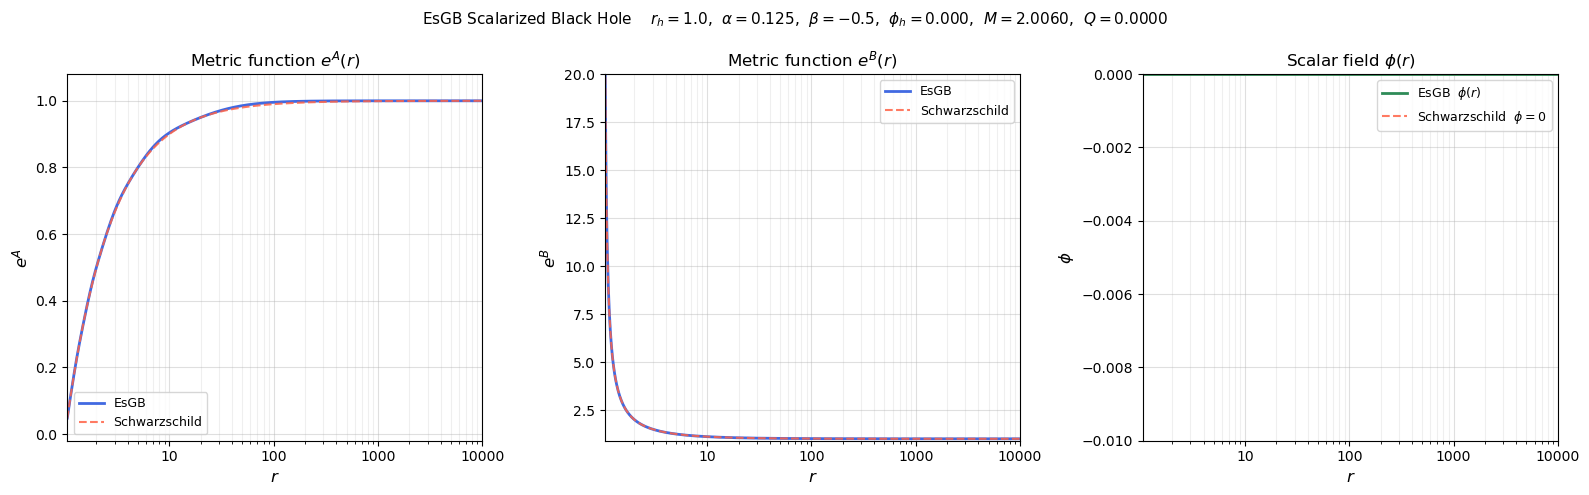

图像已保存：esgb_solution.png


In [9]:
def set_logx(ax, rmin, rmax):
    """设置对数横轴（显示数值与线性轴外观相同，类似 Mathematica LogLinearPlot）"""
    ax.set_xscale('log')
    ax.set_xlim(rmin, rmax)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(
        lambda v, _: f'{v:.3g}' if v < 100 else f'{v:.0f}'
    ))
    ax.set_xlabel(r'$r$', fontsize=12)
    ax.grid(True, which='both', alpha=0.2)
    ax.grid(True, which='major', alpha=0.4)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle(
    rf'EsGB Scalarized Black Hole    '
    rf'$r_h={rh}$,  $\alpha={alpha}$,  $\beta={beta}$,  '
    rf'$\phi_h={phi_h_sol:.3f}$,  $M={M_ADM:.4f}$,  $Q={Q:.4f}$',
    fontsize=11
)

# ── 左图：e^A ────────────────────────────────────────────────
ax = axes[0]
ax.plot(r_fine, eA_fine, lw=2,   color='royalblue', label='EsGB')
ax.plot(r_fine, eA_schw, lw=1.5, color='tomato', ls='--',
        label='Schwarzschild', alpha=0.85)
ax.set_ylabel(r'$e^A$', fontsize=12)
ax.set_title(r'Metric function $e^A(r)$')
ax.set_ylim(-0.02, 1.08)
ax.legend(fontsize=9)
set_logx(ax, r_plot_min, r_plot_max)

# ── 中图：e^B ────────────────────────────────────────────────
# eB_schw 在视界处发散，取合理上限显示
eB_ylim = min(eB_fine.max() * 1.1, 20.)
ax = axes[1]
ax.plot(r_fine, eB_fine, lw=2,   color='royalblue', label='EsGB')
ax.plot(r_fine, np.clip(eB_schw, 0, eB_ylim*2), lw=1.5, color='tomato',
        ls='--', label='Schwarzschild', alpha=0.85)
ax.set_ylabel(r'$e^B$', fontsize=12)
ax.set_title(r'Metric function $e^B(r)$')
ax.set_ylim(0.9, eB_ylim)
ax.legend(fontsize=9)
set_logx(ax, r_plot_min, r_plot_max)

# ── 右图：φ ──────────────────────────────────────────────────
ax = axes[2]
ax.plot(r_fine, phi_fine, lw=2, color='seagreen', label=r'EsGB  $\phi(r)$')
ax.axhline(0., lw=1.5, color='tomato', ls='--',
           label='Schwarzschild  $\phi=0$', alpha=0.85)
ax.set_ylabel(r'$\phi$', fontsize=12)
ax.set_title(r'Scalar field $\phi(r)$')
ax.set_ylim(bottom=-0.01)
ax.legend(fontsize=9)
set_logx(ax, r_plot_min, r_plot_max)

plt.tight_layout()
plt.savefig('esgb_solution.png', dpi=150, bbox_inches='tight')
plt.show()
print('图像已保存：esgb_solution.png')

### 模块 8：边界条件验证 & 近视界 phi 结构分析

In [ ]:
ht_sol  = u_sol[:M_sol]
Gt_sol  = u_sol[M_sol:2*M_sol]
phi_sol = u_sol[2*M_sol:3*M_sol]
dhtx_sol  = D @ ht_sol
dGtx_sol  = D @ Gt_sol
dphix_sol = D @ phi_sol
d2phix_sol = D2 @ phi_sol

# 视界处 Robin BC（正确形式）
_ph    = phi_sol[N];   _Gt   = Gt_sol[N];   _dGtx  = dGtx_sol[N]
_dp    = dphix_sol[N]; _d2p  = d2phix_sol[N]
_fdot  = 2.*_ph + 4.*beta*_ph**3
_fddot = 2. + 12.*beta*_ph**2
_denom = 2.*_Gt*(rh**2 + 4.*_dp*_fdot*alpha)
_numer = (_Gt*(-1. + 2.*_dGtx + _dp**2 + _Gt)*rh**2
          + 4.*(-2.*_dp**2*_fddot*_Gt
                - 2.*_d2p*_fdot*_Gt
                + 3.*_dp*_fdot*(1. + _Gt))*alpha)
_dhtx_bc = ht_sol[N] * _numer / _denom

print('边界条件验证：')
print(f'  ht(∞) - 1    = {ht_sol[0]-1:.3e}       (应为 0)')
print(f'  Gt(∞) - 1    = {Gt_sol[0]-1:.3e}       (应为 0)')
print(f'  phi(∞)       = {phi_sol[0]:.3e}       (应为 0)')
print(f'  Robin BC     = {dhtx_sol[N] - _dhtx_bc:.3e}   (应为 0，dhtx 视界 BC)')
php_chk = phi_h_prime_func(phi_sol[N], rh, alpha, beta)
print(f'  Neumann BC   = {dphix_sol[N]-php_chk*(rh/2):.3e}   (应为 0，phi 视界 BC)')
print(f'  ||R||_inf    = {np.max(np.abs(F(u_sol))):.3e}   (Newton 最终残差)')

print()
print('近视界 phi 结构（配点 j=N..N-10，从视界向外）：')
print(f'  {"j":>4}  {"x":>10}  {"r":>10}  {"phi":>12}')
for j in range(N, N-11, -1):
    rj = 2.*rh/(1.-x_nodes[j]) if x_nodes[j] < 1. else float('inf')
    print(f'  {j:4d}  {x_nodes[j]:10.6f}  {rj:10.4f}  {phi_sol[j]:12.8f}')

print()
print(f'视界处 dphi/dr = {php_chk:+.6f}')
